In [23]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string

import re

import os
# import sys
# from IPython.display import display, HTML
# import urllib
# import gzip

import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# import pip
# import theano
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from tensorflow.keras import initializers as initializers, regularizers, constraints
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import backend as K
# from tensorflow.keras.engine.topology import Layer
# from tensorflow.keras.utils import plot_model, np_utils
# from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Layer

[nltk_data] Downloading package punkt to /home/dayoung/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dayoung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dayoung/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def cleanString(review,stopWords):
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    sentence_token = tokenize.sent_tokenize(review)
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) 
                              if w.lower() not in stopWords and w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list) + ' . '
    
    return returnString, idx_list


def split_df(dataframe, column_name, training_split = 0.6, validation_split = 0.2, test_split = 0.2):
    """
    Splits a pandas dataframe into trainingset, validationset and testset in specified ratio.
    All sets are balanced, which means they have the same ratio for each categorie as the full set.
    Input:   dataframe        - Pandas Dataframe, should include a column for data and one for categories
             column_name      - Name of dataframe column which contains the categorical output values
             training_split   - from ]0,1[, default = 0.6
             validation_split - from ]0,1[, default = 0.2        
             test_split       - from ]0,1[, default = 0.2
                                Sum of all splits need to be 1
    Output:  train            - Pandas DataFrame of trainset
             validation       - Pandas DataFrame of validationset
             test             - Pandas DataFrame of testset
    """
    if training_split + validation_split + test_split != 1.0:
        raise ValueError('Split paramter sum should be 1.0')
        
    total = len(dataframe.index)
 
    train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
    .reset_index(drop=True).set_index('index')
    train = train.sample(frac=1)
    temp_df = dataframe.drop(train.index)
    validation = temp_df.reset_index().groupby(column_name)\
    .apply(lambda x: x.sample(frac=validation_split/(test_split+validation_split)))\
           .reset_index(drop=True).set_index('index')
    validation = validation.sample(frac=1)
    test = temp_df.drop(validation.index)
    test = test.sample(frac=1)
    
    print('Total: ', len(dataframe))
    print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
    print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))
    print('Test:', len(test), ', Percentage: ', len(test)/len(dataframe))

    return train, validation, test

def wordToSeq(text,word_index,max_sentences,max_words,max_features):
    """
    Converts a string to a numpy matrix where each word is tokenized.
    Arrays are zero-padded to max_sentences and max_words length.
    
    Input:    text           - string of sentences
              word_index     - trained word_index
              max_sentences  - maximum number of sentences allowed per document for HAN
              max_words      - maximum number of words in each sentence for HAN
              max_features   - maximum number of unique words to be tokenized
    Output:   data           - Numpy Matrix of size [max_sentences x max_words]
    """
    sentences = tokenize.sent_tokenize(text)
    data = np.zeros((max_sentences, max_words), dtype='int32')
    for j, sent in enumerate(sentences):
        if j< max_sentences:
            wordTokens = tokenize.word_tokenize(sent.rstrip('.'))
            wordTokens = [w for w in wordTokens]
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_words and word_index[word]<max_features:
                        data[j,k] = word_index[word]
                        k=k+1
                except:
                    pass
    return data


In [4]:
data_df = pd.read_csv('dataset/Reviews.csv')
data_df = data_df[['Score','Text']]
data_df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [21]:
"""
Compute average number of words in each sentence and average number of sentences in each document.
"""
n_sent = 0
n_words = 0
for i in range(data_df.shape[0]):
    sent = tokenize.sent_tokenize(data_df.loc[i,'Text'])
    for satz in sent:
        n_words += len(tokenize.word_tokenize(satz))
    n_sent += len(sent)
    
print("Average number of words in each sentence: ",round(n_words/n_sent))
print("Average number of sentences in each document: ", round(n_sent/data_df.shape[0]))

Average number of words in each sentence:  19
Average number of sentences in each document:  5


In [5]:
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_SENTENCE_NUM = 40 # maximum number of sentences in one document
MAX_WORD_NUM = 50     # maximum number of words in each sentence
EMBED_SIZE = 100      # vector size of word embedding

In [26]:
"""
Cleans raw data using the cleanString() function from above.
English stopwords are used from nltk library.
Cleaned dataset is saved in 'data_cleaned' pandas dataframe.
Labels are converted to numbers,
"""
# articles = []
# n = data_df['Text'].shape[0]
# col_number = data_df.columns.get_loc('Text')
# stopWords = set(stopwords.words('english'))
# data_cleaned = data_df.copy()
# for i in range(n):
#     temp_string,idx_string = cleanString(data_df.iloc[i,col_number],stopWords)
#     articles.append(temp_string)
#     print(str(i+1)+' of '+str(n)+" articles cleaned.",end='\r')
    
# data_cleaned.loc[:,'Text'] = pd.Series(articles,index=data_df.index)
# data_cleaned.loc[:,'Category'] = pd.Categorical(data_cleaned.Category)
# data_cleaned['Code'] = data_cleaned.Category.cat.codes
# categoryToCode = dict( enumerate(data_cleaned['Category'].cat.categories))

# data_cleaned.head()

AttributeError: 'DataFrame' object has no attribute 'Category'

In [ ]:
# Clean String

from nltk.stem import WordNetLemmatizer
from nltk import tokenize
from nltk.corpus import stopwords

def cleanString(review,stopWords):
    """
    Cleans input string using set rules.
    Cleaning rules:         Every word is lemmatized and lowercased. Stopwords and non alpha-numeric words are removed.
                            Each sentence ends with a period.
    Input:   review       - string(in sentence structure)
             stopWords    - set of strings which should be removed from review
    Output:  returnString - cleaned input string
             idx_list     - list of lists, one list is equal to one sentence. In every list are the index
                            of each word as they appeared in the non cleaned sentence
                            e.g. nonCleaned = "This is a test." -> cleaned = "This test." -> cleaned_index = [[0,3]]
    """
    # Init the Wordnet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    sentence_token = tokenize.sent_tokenize(review)
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) 
                              if w.lower() not in stopWords and w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list) + ' . '
    
    return returnString, idx_list

print("clenString example:")
print(cleanString(df_review['Text'][0],['a','the'])[0])

# df_review['Text']=df_review['Text'].apply(lambda x : cleanString(x,['a','the'])[0])

## cleanString 한 결과 저장해놓은 것
# df_review = pd.read_csv('dataset/df_review.csv')

In [6]:
data_cleaned = data_df

In [7]:


"""
Using the keras Tokenizer class a word index is built.
The most 'MAX_FEATURES' used words are tokenized to a number.
this dictionary is saved in word_index
"""
texts = []
n = data_cleaned['Text'].shape[0]
for i in range(n):
    s = data_cleaned['Text'].iloc[i]
    s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])
    texts.append(s)
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=None)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index



<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-7-b9b57f0d9043>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])


In [12]:
"""
A pre-trained word to vector is used from GloVe by Pennington et. al.
Source: https://nlp.stanford.edu/projects/glove/
The data was trained on wikipedia articles. Each word is described by a 100d vector.
"""

# Load word vectors from pre-trained dataset
embeddings_index = {}
f = open(os.path.join(os.getcwd(), 'dataset/glove.6B.100d.txt'),encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

# Search words in our word index in the pre-trained dataset
# Create an embedding matrix for our bbc dataset
min_wordCount = 0
absent_words = 0
small_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
word_counts = tokenizer.word_counts
for word, i in word_index.items():
    if word_counts[word] > min_wordCount:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            absent_words += 1
    else:
        small_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)),
      '% of total words')
print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(word_index)),
      '% of total words')


Found 400000 word vectors.
Total absent words are 66396 which is 52.37 % of total words
Words with 0 or less mentions 0 which is 0.00 % of total words


In [13]:
# display(example_df_embedding)
embedding_matrix[word_index['great']]

array([-0.013786  ,  0.38216001,  0.53236002,  0.15261   , -0.29694   ,
       -0.20558   , -0.41846001, -0.58437002, -0.77354997, -0.87866002,
       -0.37858   , -0.18516   , -0.12800001, -0.20584001, -0.22925   ,
       -0.42598999,  0.3725    ,  0.26076999, -1.07019997,  0.62915999,
       -0.091469  ,  0.70348001, -0.4973    , -0.77691001,  0.66044998,
        0.09465   , -0.44893   ,  0.018917  ,  0.33146   , -0.35021999,
       -0.35789001,  0.030313  ,  0.22253001, -0.23236001, -0.19719   ,
       -0.0053125 , -0.25848001,  0.58081001, -0.10705   , -0.17845   ,
       -0.16205999,  0.087086  ,  0.63028997, -0.76648998,  0.51618999,
        0.14072999,  1.01900005, -0.43136001,  0.46138   , -0.43584999,
       -0.47567999,  0.19226   ,  0.36065   ,  0.78987002,  0.088945  ,
       -2.78139997, -0.15366   ,  0.01015   ,  1.17980003,  0.15167999,
       -0.050112  ,  1.26259995, -0.77526999,  0.36030999,  0.95761001,
       -0.11385   ,  0.28035   , -0.02591   ,  0.31246001, -0.15

In [16]:
"""
Split Pandas Dataframe into train, validation and testset.
Convert data to keras conforming form
"""
# print(categoryToCode)
train, validation, test = split_df(data_cleaned, 'Score',0.8,0.1,0.1)

#Training
paras = []
for i in range(train['Text'].shape[0]):
    sequence = wordToSeq(train['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_train = np.array(paras)
# y_train = to_categorical(train['Score'],categoryToCode)
y_train = pd.get_dummies(train['Score'])

#Validation
paras = []
for i in range(validation['Text'].shape[0]):
    sequence = wordToSeq(validation['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_val = np.array(paras)
# y_val = to_categorical(validation['Score'],categoryToCode)
y_val = pd.get_dummies(validation['Score'])
#Test
paras = []
for i in range(test['Text'].shape[0]):
    sequence = wordToSeq(test['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_test = np.array(paras)
# y_test = to_categorical(test['Score'],categoryToCode)
y_test = pd.get_dummies(test['Score'])

Total:  568454
Training:  454763 , Percentage:  0.7999996481685413
Validation:  56846 , Percentage:  0.10000105549437598
Test: 56845 , Percentage:  0.09999929633708268


In [ ]:
# with tf.device("/gpu:0"):

In [19]:
class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self._trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]


In [24]:
"""
Create Keras functional model for hierarchical attention network
"""
with tf.device("/gpu:0"):
    embedding_layer = Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix], 
                                input_length=MAX_WORD_NUM, trainable=False,name='word_embedding')

    # Words level attention model
    word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
    word_sequences = embedding_layer(word_input)
    word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_sequences)
    word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 
    word_att,word_coeffs = AttentionLayer(EMBED_SIZE,True,name='word_attention')(word_dense)
    wordEncoder = Model(inputs = word_input,outputs = word_att)

    # Sentence level attention model
    sent_input = Input(shape=(MAX_SENTENCE_NUM,MAX_WORD_NUM), dtype='int32',name='sent_input')
    sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)
    sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
    sent_dense = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
    sent_att,sent_coeffs = AttentionLayer(EMBED_SIZE,return_coefficients=True,name='sent_attention')(sent_dense)
    sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
    preds = Dense(5, activation='softmax',name='output')(sent_drop)

    # Model compile
    model = Model(sent_input, preds)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    print(wordEncoder.summary())
    print(model.summary())


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_input (InputLayer)      [(None, 50)]              0         
_________________________________________________________________
word_embedding (Embedding)   (None, 50, 100)           12677700  
_________________________________________________________________
word_gru (Bidirectional)     (None, 50, 100)           45600     
_________________________________________________________________
word_dense (Dense)           (None, 50, 100)           10100     
_________________________________________________________________
word_attention (AttentionLay [(None, 100), (None, 50,  10200     
Total params: 12,743,600
Trainable params: 65,900
Non-trainable params: 12,677,700
_________________________________________________________________
None
Model: "model_3"
_________________________________________________________________
Layer (type)        

9096/9096 [==============================] - 6839s 752ms/step - loss: 0.7776 - acc: 0.7142 - val_loss: 0.7456 - val_acc: 0.7244
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


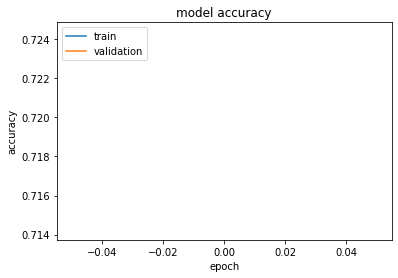

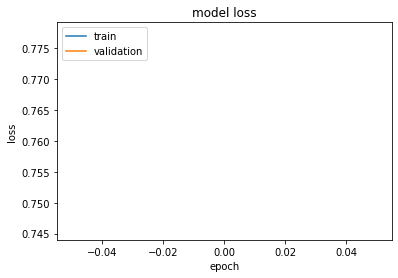

In [26]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1, batch_size=50)

print(history.history.keys())
# Plot of accuracy in each epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(x_test,y_test)
print("Test set accuracy: ",acc)
print("Test set loss: ", loss)


In [ ]:
# Saves the model in a hdf5 file
model.save('models/english_review_epoch1.h5')

In [ ]:
# Load model from saved hdf5 file
model = load_model('models/english_review_epoch1.h5',custom_objects={'AttentionLayer': AttentionLayer})

# articleDB = pd.DataFrame(columns = ['Title','Summary','Text','Category','Tags'])

In [ ]:
article=review_df[:5]['Text']

In [ ]:
# Clean article with pre described rules
article_cleaned,idx_list = cleanString(article,stopWords)
input_array = wordToSeq(article_cleaned,word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)

In [ ]:
sent_att_weights = Model(inputs=sent_input,outputs=sent_coeffs)
output_array = sent_att_weights.predict(np.resize(input_array,(1,MAX_SENTENCE_NUM,MAX_WORD_NUM)))

# Get n sentences with most attention in document
n_sentences = 5
sent_index = output_array.flatten().argsort()[-n_sentences:]
sent_index = np.sort(sent_index)
sent_index = sent_index.tolist()

# Create summary using n sentences
sent_list = tokenize.sent_tokenize(article)
summary = [sent_list[i] for i in sent_index]